# 长短期记忆网络LSTM
⻓期以来，隐变量模型存在着⻓期信息保存和短期输⼊缺失的问题。解决这⼀问题的最早⽅法之⼀是⻓短期存储器（long short-term memory，LSTM）

## 1. 门控记忆元
可以说，⻓短期记忆⽹络的设计灵感来⾃于计算机的逻辑⻔。⻓短期记忆⽹络引⼊了记忆元（memory cell），
或简称为单元（cell）。有些⽂献认为记忆元是隐状态的⼀种特殊类型，它们与隐状态具有相同的形状，其设
计⽬的是⽤于记录附加的信息。为了控制记忆元，我们需要许多⻔。其中⼀个⻔⽤来从单元中输出条⽬，我
们将其称为输出⻔（output gate）。另外⼀个⻔⽤来决定何时将数据读⼊单元，我们将其称为输⼊⻔（input
gate）。我们还需要⼀种机制来重置单元的内容，由遗忘⻔（forget gate）来管理，这种设计的动机与⻔控循
环单元相同，能够通过专⽤机制决定什么时候记忆或忽略隐状态中的输⼊。

+ 输入门，忘记门和输出门
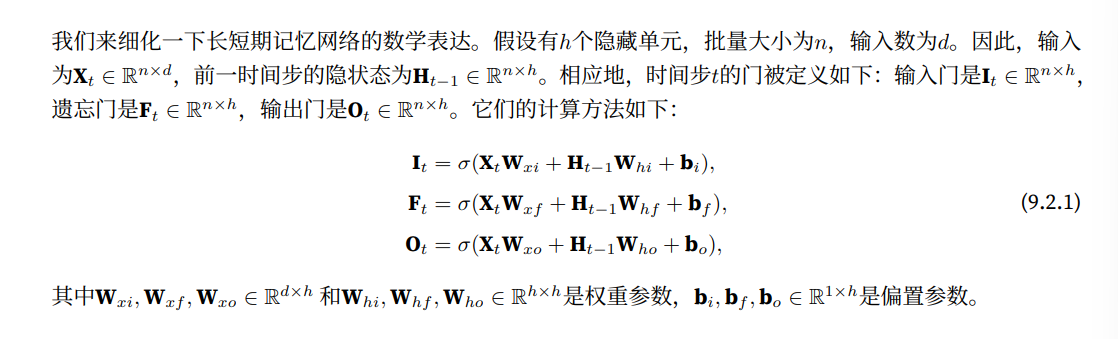
+ 候选记忆元
类似GRU候选隐状态
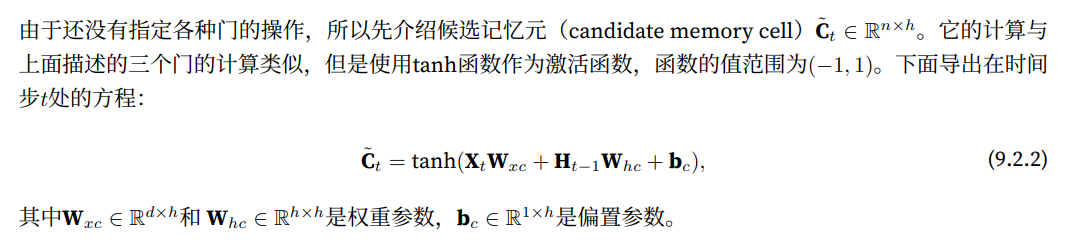
+ 记忆元
类似GRU更新门
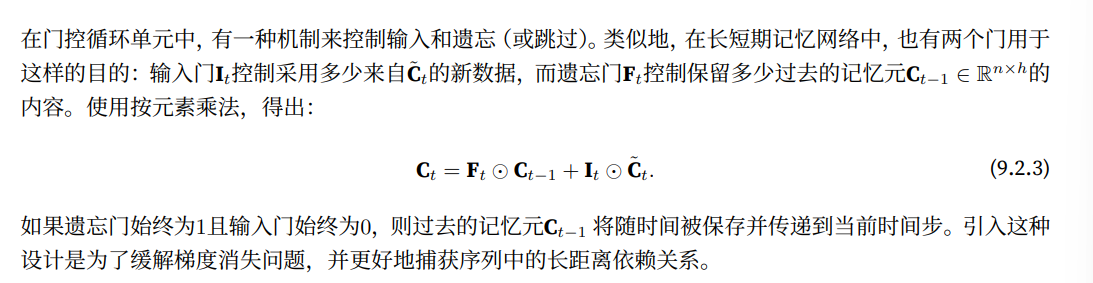
+ 隐状态
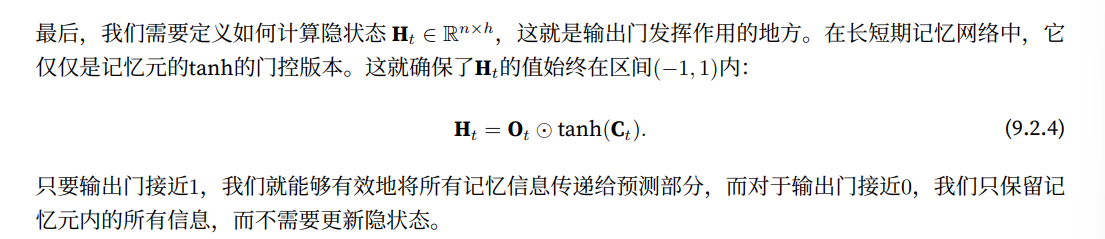
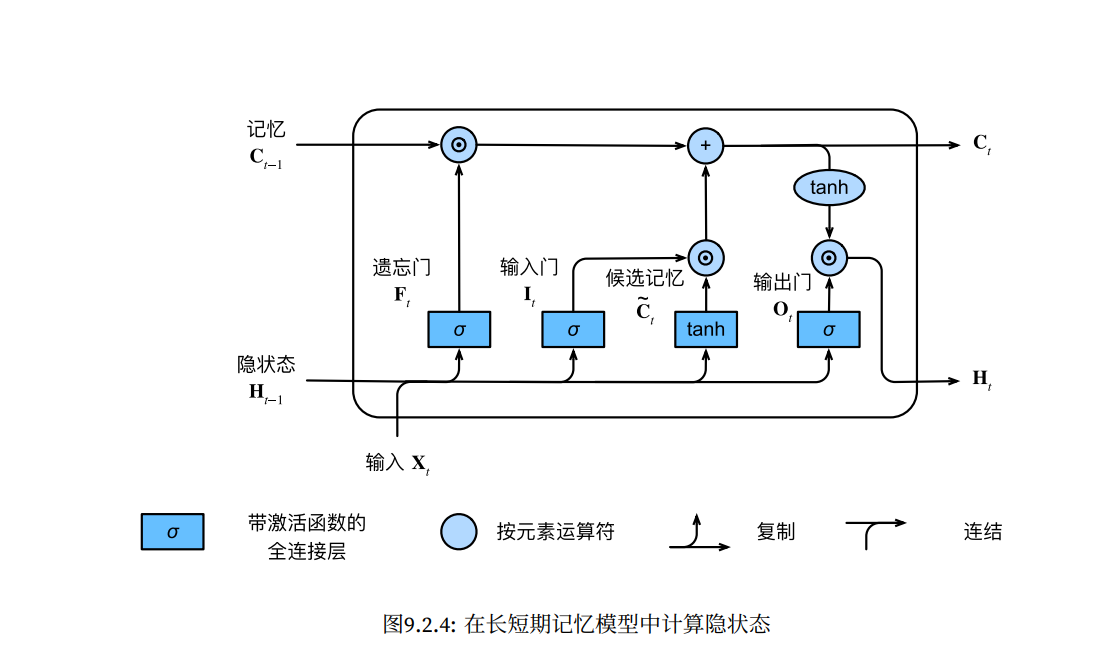

## 2. 从零实现

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

+ 初始化模型参数

In [3]:
def get_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size
    
    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01
    
    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))
    
    W_xi, W_hi, b_i = three() # 输入门参数
    W_xf, W_hf, b_f = three() # 遗忘门参数
    W_xo, W_ho, b_o = three() # 输出门参数
    W_xc, W_hc, b_c = three() # 候选记忆元参数

    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q]

    for param in params:
        param.requires_grad_(True)
    return params

+ 定义模型  

在初始化函数中，⻓短期记忆⽹络的隐状态需要返回⼀个额外的记忆元，单元的值为0，形状为（批量⼤⼩，
隐藏单元数）。

In [4]:
def init_lstm_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),
           torch.zeros((batch_size, num_hiddens), device=device))

In [5]:
# 实际模型的定义与我们前⾯讨论的⼀样：提供三个⻔和⼀个额外的记忆元。请注意，只有隐状态才会传递到输出层，⽽记忆元Ct不直接参与输出计算。

def lstm(inputs, state, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q] = params
    (H, C) = state
    outputs = []
    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * torch.tanh(C)
        Y = (H @ W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H, C)

+ 训练和预测

perplexity 1.1, 11361.3 tokens/sec on cpu
time traveller wo gertar anthore it s ageld the very young man k
travelleryou can show black is white by argument said filby


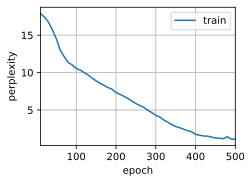

In [7]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_lstm_params,
                           init_lstm_state, lstm)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## 2. 简洁实现

perplexity 1.0, 16769.2 tokens/sec on cpu
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


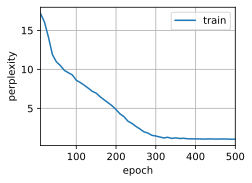

In [8]:
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## 总结
+ ⻓短期记忆⽹络有三种类型的⻔：输⼊⻔、遗忘⻔和输出⻔。
+ ⻓短期记忆⽹络的隐藏层输出包括“隐状态”和“记忆元”。只有隐状态会传递到输出层，⽽记忆元完全属于内部信息。
+ ⻓短期记忆⽹络可以缓解梯度消失和梯度爆炸。
